In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time, json
import sys
sys.path.append("../")
sys.path.append("../chess_llm_interpretability")
import os
import torch
import numpy as np

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-10-22 18:47:06 __main__ INFO     torch.__version__='2.4.1+cu121', torch.version.cuda='12.1'


In [28]:
from src.models import ModelandTokenizer

# MODEL_KEY = "meta-llama/Llama-3.2-3B-Instruct"
# MODEL_KEY = "meta-llama/Llama-3.1-8B-Instruct"

# MODEL_KEY = "meta-llama/Llama-3.2-3B"
# MODEL_KEY = "google/gemma-2-2b"
# MODEL_KEY = "meta-llama/Llama-3.1-8B"
MODEL_KEY = "meta-llama/Llama-3.2-1B"

mt = ModelandTokenizer(
    model_key=MODEL_KEY,
    # torch_dtype=torch.float32,
)

2024-10-22 18:55:13 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
2024-10-22 18:55:14 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.2-1B> | size: 2357.131 MB | dtype: torch.float16 | device: cuda:0


In [30]:
from transformers import AutoModelForCausalLM

finetuned_path = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "chess_model_finetuned")
finetuned_path = os.path.join(finetuned_path, os.listdir(finetuned_path)[-1])
model = AutoModelForCausalLM.from_pretrained(finetuned_path, torch_dtype=torch.float32).to("cuda")

In [31]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [32]:
import baukit
layer_name = mt.mlp_module_name_format.format(5)

w_o = baukit.get_module(mt._model, layer_name).down_proj.weight.data.to(torch.float32)
w_f = baukit.get_module(model, layer_name).down_proj.weight.data.to(torch.float32)

torch.allclose(w_o, w_f, atol = 1e-4)  # Check if weights are the same

False

In [33]:
mt._model = model  # Replace the model in the ModelandTokenizer with the fine-tuned model

## Initial Test

In [8]:
system_prompt = "You are a ChessBot, who can play chess with users. The user always plays as white and you play as black. The user will give their move in PGN format. You should respond with your move in PGN format. If you cannot find a move, you should resign."

In [9]:
from chess_llm_interpretability import chess_utils
from typing import Optional


def format_move(move):
    if "." in move:
        move = move.split(".")[-1]
    if move[-1] == "#":
        move = move[:-1]
    return move.strip()

def format_pgn_string(pgn_string):
    white_moves = []
    black_moves = []
    for idx, move in enumerate(pgn_string.split(" ")):    
        if idx % 2 == 0:
            white_moves.append(format_move(move))
        else:
            black_moves.append(format_move(move))
    return white_moves, black_moves

def get_white_and_black_moves(pgn_string):
    white_move_indices = chess_utils.get_all_white_pos_indices(pgn_string)
    white_moves = [
        format_move("".join([pgn_string[jdx] for jdx in white_move_indices[idx]]))
        for idx in range(len(white_move_indices))
    ]

    black_move_indices = chess_utils.get_all_black_pos_indices(pgn_string)
    black_moves = [
        format_move("".join([pgn_string[jdx] for jdx in black_move_indices[idx]]))
        for idx in range(len(black_move_indices))
    ]

    return white_moves, black_moves

def get_prompt(
    pgn_string: str,
    query_move: int,
    white_moves: Optional[list[str]] = None,
    black_moves: Optional[list[str]] = None,
    is_chat_mode: bool = False,
):
    if white_moves is None or black_moves is None:
        white_moves, black_moves = get_white_and_black_moves(pgn_string)
    
    white_move_indices = chess_utils.get_all_white_pos_indices(pgn_string)
    pgn_state = pgn_string[:white_move_indices[query_move-1][-1] + 1]
    if is_chat_mode == False:
        return dict(
            prompt=f"PGN of a chess game: {pgn_state}",
            answer=black_moves[query_move-1],
            pgn_state=pgn_state,
        )
    
    else:
        conversation = [
            {"role": "system", "content": system_prompt},
            # {"role": "user", "content": "d4"},
            # {"role": "assistant", "content": "c5"},
            # {"role": "user", "content": "c3"},
        ]
        for idx, (white_move, black_move) in enumerate(zip(white_moves[:query_move], black_moves[:query_move])):
            conversation.append({"role": "user", "content": white_move})
            if idx != query_move-1:
                conversation.append({"role": "assistant", "content": black_move})
        formatted_chat = mt.tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
        return dict(
            prompt = formatted_chat, 
            answer = black_moves[query_move-1],
            pgn_state = pgn_state,
        )

pgn_string = "1.e4 e5 2.Bc4 Bc5 3.c3 Nf6 4.d3 d6 5.h3 Be6 6.Bb5+ c6 7.Ba4 Qd7 8.b4 Bb6 9.Na3 h6 10.b5 c5 11.g4 Qe7 12.g5 Ng8 13.h4 hxg5 14.Bxg5 f6 15.Be3 Nd7 16.d4 exd4 17.cxd4 cxd4 18.Bxd4 Ba5+ 19.Kf1 b6 20.Rc1 Bb4 21.Nc2 Bc4+ 22.Ne2 Qxe4 23.Rh3 Bxe2+ 24.Qxe2 Qxe2+ 25.Kxe2 Bc5 26.Bb3 Ne7 27.Bxc5 dxc5 28.Rd1 Ne5 29.Re1 N7g6 30.Kf1 O-O-O 31.Be6+ Kb8 32.Bf5 Nxh4 33.Ne3 g6 34.Be6 Rd6 35.Bb3 g5 36.Nd5 c4 37.Bxc4 Nxc4 38.Nxb6 axb6 39.Rc1 Nd2+ 40.Ke2 Re8+ 41.Kd1 Nb3+ 42.Kc2 Nxc1 43.Kxc1"
query_move = 5

request = get_prompt(
    pgn_string, query_move,
    is_chat_mode=False
)

print(request["prompt"])
print(request["answer"])
print(request["pgn_state"])

2024-10-22 18:47:09 numexpr.utils INFO     Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-10-22 18:47:09 numexpr.utils INFO     NumExpr defaulting to 8 threads.
PGN of a chess game: 1.e4 e5 2.Bc4 Bc5 3.c3 Nf6 4.d3 d6 5.h3
Be6
1.e4 e5 2.Bc4 Bc5 3.c3 Nf6 4.d3 d6 5.h3


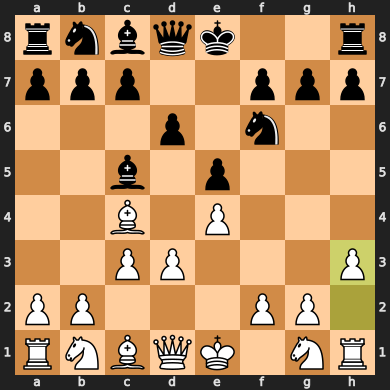

In [10]:
board = chess_utils.pgn_string_to_board(request["pgn_state"])
board

In [11]:
legal_black_moves = [board.san(move) for move in board.legal_moves]
# legal_black_moves

In [12]:
from typing import List, Optional

def get_next_move_by_LM(
    request: dict,
    debug: bool = False,
):
    prompt = request["prompt"]
    answer = request["answer"]
    pgn_state = request["pgn_state"]

    inputs = mt.tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    inputs = {key: tensor.to(mt.device) for key, tensor in inputs.items()}

    outputs = mt._model.generate(
        **inputs, 
        max_new_tokens=12,
        do_sample=False, 
        # temperature=0.01
    )
    # logger.debug(f"Generated tokens:\n{outputs}")

    decoded_output = mt.tokenizer.decode(outputs[0][inputs['input_ids'].size(1):], skip_special_tokens=True)

    if debug:
        logger.debug(f"{pgn_state=} | {answer=}")
        logger.debug(f"{prompt=}")
        logger.debug("-"*50)
        logger.debug(f"Decoded output:\n{decoded_output}")

    return decoded_output.strip().split(" ")[0].strip()

next_black_move = get_next_move_by_LM(request, debug = True)
logger.info(f"{next_black_move} | {next_black_move in legal_black_moves=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


2024-10-22 18:47:09 __main__ INFO     O-O | next_black_move in legal_black_moves=True


## Check Accuracy of Legal Moves

In [13]:
from datasets import load_dataset

dataset = load_dataset("adamkarvonen/chess_games", data_files="lichess_100mb.zip", streaming=True)

2024-10-22 18:47:10 datasets INFO     PyTorch version 2.4.1 available.


Repo card metadata block was not found. Setting CardData to empty.


2024-10-22 18:47:10 huggingface_hub.repocard WARNING  Repo card metadata block was not found. Setting CardData to empty.


In [14]:
limit = 100
pgn_transcripts = []
for d in dataset["train"]:
    pgn_transcripts.append(d["transcript"])
    if len(pgn_transcripts) >= limit:
        break

In [15]:
track_wrong_ans = []
LIMIT_MOVES = 30
track_accuracy = {move_idx: {"n_correct": 0, "n_total": 0} for move_idx in range(1, LIMIT_MOVES)}

from tqdm import tqdm
for pgn_string in tqdm(pgn_transcripts):
    white_moves, black_moves = get_white_and_black_moves(pgn_string)
    for query_move in range(
        1, min(
            len(white_moves), 
            len(black_moves), 
            LIMIT_MOVES - 1
        )
    ):
        track_accuracy[query_move]["n_total"] += 1

        request = get_prompt(
            pgn_string, query_move,
            white_moves=white_moves,
            black_moves=black_moves,
            # is_chat_mode=("instruct" in MODEL_KEY.lower()) or ("chat" in MODEL_KEY.lower())
            is_chat_mode=False
        )

        next_black_move = get_next_move_by_LM(
            request, debug=False
        )


        board = chess_utils.pgn_string_to_board(request["pgn_state"])
        legal_black_moves = [board.san(move) for move in board.legal_moves]

        track_accuracy[query_move]["n_correct"] += next_black_move in legal_black_moves

        if next_black_move not in legal_black_moves:
            track_wrong_ans.append(dict(
                pgn_string=pgn_string,
                query_move=query_move,
                next_black_move=next_black_move,
            ))


  0%|          | 0/100 [00:00<?, ?it/s]/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

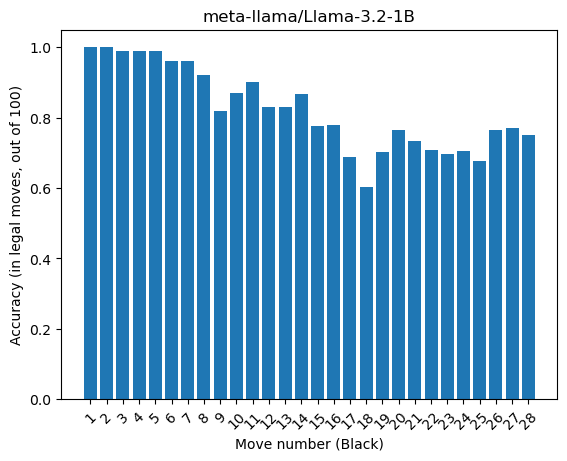

In [16]:
accuracy_legal = []
for query_move in range(1, LIMIT_MOVES):
    if track_accuracy[query_move]["n_total"] == 0:
        break
    accuracy_legal.append(
        track_accuracy[query_move]["n_correct"] / track_accuracy[query_move]["n_total"]
    )

from matplotlib import pyplot as plt
plt.bar(x = range(1, len(accuracy_legal)+1), height = accuracy_legal)
plt.xticks(range(1, len(accuracy_legal)+1), rotation=45)
plt.xlabel("Move number (Black)")
plt.ylabel(f"Accuracy (in legal moves, out of {limit})")
plt.title(f"{MODEL_KEY}")

plt.show()

In [17]:
track_wrong_ans[0]

{'pgn_string': '1.d4 e6 2.c4 Nf6 3.Nc3 Bb4 4.Bg5 h6 5.Bxf6 Qxf6 6.Nf3 O-O 7.e4 Bxc3+ 8.bxc3 d6 9.Bd3 e5 10.h3 c5 11.d5 b6 12.Nh2 Qe7 13.O-O Nd7 14.f4 exf4 15.Rxf4 Ne5 16.Bf1 Ba6 17.Ng4 f6 18.Qe1 Bc8 19.Qg3 Bxg4 20.hxg4 Rf7 21.Be2 Qd7 22.Raf1 Qa4 23.g5 hxg5 24.Rf5 Qxa2 25.Bh5 Rff8 26.Qh3 Qxc4 27.Rxe5 fxe5 28.Qe6+ Kh8 29.Bf7 Qd3 30.Rf3 Qxf3 31.gxf3 g6 32.Qf6+ Kh7 33.Qxg6+ Kh8 34.Qh6#',
 'query_move': 20,
 'next_black_move': 'Qxg3'}

PGN of a chess game: 1.d4 e6 2.c4 Nf6 3.Nc3 Bb4 4.Bg5 h6 5.Bxf6 Qxf6 6.Nf3 O-O 7.e4 Bxc3+ 8.bxc3 d6 9.Bd3 e5 10.h3 c5 11.d5 b6 12.Nh2 Qe7 13.O-O Nd7 14.f4 exf4 15.Rxf4 Ne5 16.Bf1 Ba6 17.Ng4 f6 18.Qe1 Bc8 19.Qg3 Bxg4 20.hxg4
Rf7
1.d4 e6 2.c4 Nf6 3.Nc3 Bb4 4.Bg5 h6 5.Bxf6 Qxf6 6.Nf3 O-O 7.e4 Bxc3+ 8.bxc3 d6 9.Bd3 e5 10.h3 c5 11.d5 b6 12.Nh2 Qe7 13.O-O Nd7 14.f4 exf4 15.Rxf4 Ne5 16.Bf1 Ba6 17.Ng4 f6 18.Qe1 Bc8 19.Qg3 Bxg4 20.hxg4


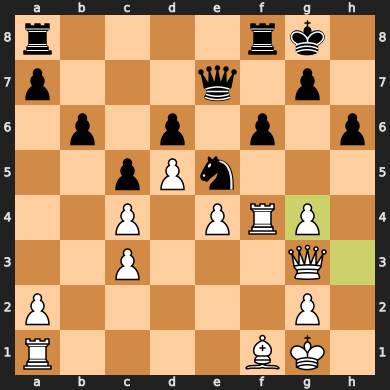

In [18]:
request = get_prompt(
    pgn_string=track_wrong_ans[0]["pgn_string"],
    query_move=track_wrong_ans[0]["query_move"],
    is_chat_mode=False
)
print(request["prompt"])
print(request["answer"])
print(request["pgn_state"])

board = chess_utils.pgn_string_to_board(request["pgn_state"])
board

In [19]:
legal_black_moves = [board.san(move) for move in board.legal_moves]
legal_black_moves

['Kh8',
 'Kh7',
 'Kf7',
 'Rfe8',
 'Rfd8',
 'Rfc8',
 'Rfb8',
 'Rf7',
 'Rae8',
 'Rad8',
 'Rac8',
 'Rab8',
 'Qe8',
 'Qd8',
 'Qf7',
 'Qd7',
 'Qc7',
 'Qb7',
 'Qe6',
 'Nf7',
 'Nd7',
 'Ng6',
 'Nc6',
 'Nxg4',
 'Nxc4',
 'Nf3+',
 'Nd3',
 'g6',
 'a6',
 'h5',
 'f5',
 'b5',
 'g5',
 'a5']

In [20]:
next_black_move = get_next_move_by_LM(
    request, debug=True
)
next_black_move

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'Qxg3'

In [24]:
next_black_move in legal_black_moves

False

In [25]:
request["answer"] in legal_black_moves

True

In [34]:
prompt = "The Space Needle is in the city of"

inputs = mt.tokenizer(prompt, return_tensors="pt", add_special_tokens=False).to(mt.device)
outputs = mt._model.generate(
    **inputs, 
    max_new_tokens=12,
    do_sample=False, 
    # temperature=0.01
)
# logger.debug(f"Generated tokens:\n{outputs}")

decoded_output = mt.tokenizer.decode(outputs[0][inputs['input_ids'].size(1):], skip_special_tokens=True)
decoded_output

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


' the city. 1.e4 e5 2.N'